# Análisis de datos transcriptómicos

## Pregunta

> ¿Cómo podemos identificar genes diferencialmente expresados entre dos condiciones biológicas a partir de datos de RNA-Seq?

## Objetivos

**General:**

> Brindar una visión general del flujo de trabajo para el **análisis de expresión diferencial** a partir de datos de RNA-Seq, que permita comparar dos **condiciones experimentales** e identificar los genes con **diferencias de expresión estadísticamente significativas**, utilizando **Python** y la biblioteca **pydeseq2**.

**Específicos:**

> 1. Comprender las etapas principales del flujo de análisis de expresión diferencial (normalización, estimación de dispersión, pruebas estadísticas).
> 2. Utilizar el paquete pyDESeq para realizar un análisis de expresión diferencial a partir de una matriz de conteos y metadatos experimentales.
> 3. Interpretar los resultados del análisis, incluyendo valores de fold change, p-values y adjusted p-values.
> 4.Generar visualizaciones básicas (como gráficos MA o volcanos) para resumir los resultados y facilitar su interpretación.
> 5. Consolidar el flujo completo desde la carga de datos hasta la obtención de resultados biológicamente interpretables.

## 1. ¿Qué es el análisis de expresión diferencial?

Un organismo puede tener miles de genes; algunos de ellos están siempre activos y son necesarios para su funcionamiento básico. Sin embargo, existen otros genes cuya expresión puede “apagarse” o “encenderse” en respuesta a determinadas condiciones ambientales o funcionales.

Los estudios de **expresión diferencial** buscan precisamente determinar **qué genes cambian su nivel de expresión** entre dos o más condiciones (por ejemplo, una **condición basal** frente a una **condición experimental**), lo que permite identificar posibles **genes regulados diferencialmente** y comprender mejor los procesos biológicos subyacentes.

## 2. Flujo general del análisis de expresión diferencial

De manera general, los pasos a seguir para realizar un **análisis de expresión diferencial** se pueden resumir en las siguientes etapas:

1. **Lectura de datos:** Importar la **tabla de abundancias** o matriz de conteos que contiene el número de lecturas por gen y por muestra.  
2. **Análisis exploratorio de los datos:** Generar **gráficas y estadísticas descriptivas** que permitan obtener una visión general y detectar posibles anomalías o sesgos en los datos.  
3. **Filtrado de datos:** Eliminar genes con **baja expresión** o conteos poco significativos para evitar ruido en el análisis.  
4. **Normalización:** Ajustar los datos para hacer las **muestras comparables** entre sí, compensando diferencias en la profundidad de secuenciación.  
5. **Pruebas estadísticas:** Aplicar métodos estadísticos para **inferir la expresión diferencial**, es decir, detectar los genes cuyo nivel de expresión cambia significativamente entre condiciones más allá de la variación aleatoria.  
6. **Interpretación de resultados:** Clasificar los genes como **no significativos**, **sobreexpresados** o **subexpresados**, de acuerdo con los valores de corte seleccionados para el nivel de significancia (*padjust*, FDR) y el cambio de expresión (*log₂ fold change*).  
7. **Representación visual de los resultados:** Crear gráficas como **MA plots**, **volcano plots** o **heatmaps** para facilitar la interpretación y comunicación de los hallazgos.  
8. **Análisis posterior:** Explorar las **funciones biológicas** de los genes diferencialmente expresados mediante análisis de enriquecimiento o anotación funcional.

En las siguientes secciones realizaremos de manera práctica los pasos del **1 al 7**, utilizando **Python** y la biblioteca **pyDESeq**.

## 3. Lectura de datos (tabla de conteos)

En este ejemplo trabajaremos con la **tabla de conteos** relacionada con la expresión del gen **Pasilla** en *Drosophila melanogaster*, generada previamente en la clase de alineamiento. Esta tabla contiene el **número de lecturas asignadas a cada gen** en las **siete muestras** asociadas a las condiciones *treated* (3 muestras) y *untreated* (4 muestras). Estos datos constituyen el **punto de partida** para el análisis de expresión diferencial.

Para la lectura de los datos utilizaremos la biblioteca [`pandas`](https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf), una herramienta fundamental en Python para la manipulación y análisis de datos en formato tabular.


In [1]:
# Cargar la biblioteca pandas
import pandas as pd



# Imprimesión del número de renglones y columnas
df_count = pd.read_csv('../tmp/All_counts_pasilla.txt', sep="\t", index_col=0)
df_count

,sampleGSM461176,sampleGSM461177,sampleGSM461178,sampleGSM461179,sampleGSM461180,sampleGSM461181,sampleGSM461182
ID=FBgn0000003,452,473,730,498,734,1030,268
ID=FBgn0000008,179,261,194,165,196,201,196
ID=FBgn0000014,7,0,0,3,1,1,4
ID=FBgn0000015,1,1,2,2,1,1,1
ID=FBgn0000017,9702,10088,7066,7687,6534,8085,6989
...,...,...,...,...,...,...,...
ID=FBgn0290417,192,202,221,144,199,256,208
ID=FBgn0290418,1347,1725,1702,1145,1576,1856,1724
ID=FBgn0290419,2536,3188,2818,1121,1342,1726,2850
ID=FBgn0290420,172,176,203,146,173,222,201


Cambiaremos y reordenaremos los nombres de las muestras para que sean más claros. Las muestras **GSM461176–GSM461178** y **GSM461182** pertenecen a la condición *“Untreated”*, mientras que las muestras **GSM461179–GSM461181** corresponden a la condición *“Treated”*. Esta asignación facilitará la interpretación de los resultados durante el análisis diferencial de expresión.

In [2]:
# Reordenar el DataFrame
x = list(range(3, 6)) + list(range(0, 3))+[6]
print(x)
df_count = df_count.iloc[:,x]

# Reasignando los nombres de columnas
df_count.columns = [f'Treated_{str(i)}' for i in range(1, 4)] + ['Untreated_' + str(i) for i in range(1, 5)]

display(df_count)


[3, 4, 5, 0, 1, 2, 6]


,Treated_1,Treated_2,Treated_3,Untreated_1,Untreated_2,Untreated_3,Untreated_4
ID=FBgn0000003,498,734,1030,452,473,730,268
ID=FBgn0000008,165,196,201,179,261,194,196
ID=FBgn0000014,3,1,1,7,0,0,4
ID=FBgn0000015,2,1,1,1,1,2,1
ID=FBgn0000017,7687,6534,8085,9702,10088,7066,6989
...,...,...,...,...,...,...,...
ID=FBgn0290417,144,199,256,192,202,221,208
ID=FBgn0290418,1145,1576,1856,1347,1725,1702,1724
ID=FBgn0290419,1121,1342,1726,2536,3188,2818,2850
ID=FBgn0290420,146,173,222,172,176,203,201


## 4. Análisis exploratorio de los datos

Una vez filtrados los datos, realizaremos un análisis exploratorio para examinar su comportamiento y distribución. Este análisis se llevará a cabo de forma visual, mediante una serie de gráficas que nos permitirán identificar patrones o posibles anomalías en los datos.  

Para ello utilizaremos la biblioteca **`seaborn`**, que se estudió en la sesión previa.  


### 4.1 Distribución de los conteos por muestra

La primera gráfica que generaremos será un **boxplot**, en el que el eje **X** representa las muestras y el eje **Y** la **distribución de los conteos**.  

Esta gráfica es importante porque permite **visualizar la variabilidad y la dispersión** de los datos entre muestras, identificar **valores atípicos** y detectar posibles **diferencias en la escala o distribución** de los conteos. En el contexto del análisis de expresión génica, el boxplot ayuda a evaluar si las muestras presentan comportamientos similares o si existen sesgos sistemáticos que podrían afectar el análisis posterior.


> **Nota:**  
> Para todas las gráficas que generaremos en esta sección, trabajaremos con los datos **transformados**, aplicando una transformación **log₂**. Esta transformación actúa como una **pseudo-normalización**, permitiendo manejar mejor la **distribución asimétrica de los conteos** y facilitando la **comparación visual entre muestras**.
>
> Para realizar la transformación utilizaremos la función `log2` de la biblioteca **NumPy**.


In [3]:
# Cargando la biblioteca
import numpy as np

# Calcular el log2 de la tabla de conteos
df_log = np.log2(df_count + 1)

display(df_log)

,Treated_1,Treated_2,Treated_3,Untreated_1,Untreated_2,Untreated_3,Untreated_4
ID=FBgn0000003,8.962896,9.521600,10.009829,8.823367,8.888743,9.513728,8.071462
ID=FBgn0000008,7.375039,7.622052,7.658211,7.491853,8.033423,7.607330,7.622052
ID=FBgn0000014,2.000000,1.000000,1.000000,3.000000,0.000000,0.000000,2.321928
ID=FBgn0000015,1.584963,1.000000,1.000000,1.000000,1.000000,1.584963,1.000000
ID=FBgn0000017,12.908393,12.673972,12.981210,13.244215,13.300496,12.786882,12.771077
...,...,...,...,...,...,...,...
ID=FBgn0290417,7.179909,7.643856,8.005625,7.592457,7.665336,7.794416,7.707359
ID=FBgn0290418,10.162391,10.622967,10.858758,10.396605,10.753217,10.733863,10.752381
ID=FBgn0290419,10.131857,10.391244,10.754052,11.308908,11.638888,11.460968,11.477252
ID=FBgn0290420,7.199672,7.442943,7.800900,7.434628,7.467606,7.672425,7.658211


Por otra parte, los datos están en **formato ancho (wide)**, pero necesitamos que estén en **formato largo (long)** para trabajar con ellos en `seaborn`. Para ello utilizaremos la función `melt` de **pandas**, que transforma la tabla adecuadamente. Además, agregaremos una columna con el nombre de la **condición** a la que pertenece cada muestra:

In [4]:
# Transformando la tabla de formato wide a formato long
df_log_melt = df_log.melt(var_name='Sample', value_name='Value')
display(df_log_melt)

# Incorporando la columna Cond, para indicar la condición de cada muestra
df_log_melt['Condition'] = df_log_melt['Sample'].str.replace('_.$', '', regex=True)
display(df_log_melt)

,Sample,Value
0,Treated_1,8.962896
1,Treated_1,7.375039
2,Treated_1,2.000000
3,Treated_1,1.584963
4,Treated_1,12.908393
...,...,...
125099,Untreated_4,7.707359
125100,Untreated_4,10.752381
125101,Untreated_4,11.477252
125102,Untreated_4,7.658211


,Sample,Value,Condition
0,Treated_1,8.962896,Treated
1,Treated_1,7.375039,Treated
2,Treated_1,2.000000,Treated
3,Treated_1,1.584963,Treated
4,Treated_1,12.908393,Treated
...,...,...,...
125099,Untreated_4,7.707359,Untreated
125100,Untreated_4,10.752381,Untreated
125101,Untreated_4,11.477252,Untreated
125102,Untreated_4,7.658211,Untreated


Con `df_LogMelt`, podemos generar la **gráfica de cajas** utilizando la función `boxplot` de **seaborn**. Esta gráfica permitirá visualizar la **distribución de los conteos** por muestra y condición.

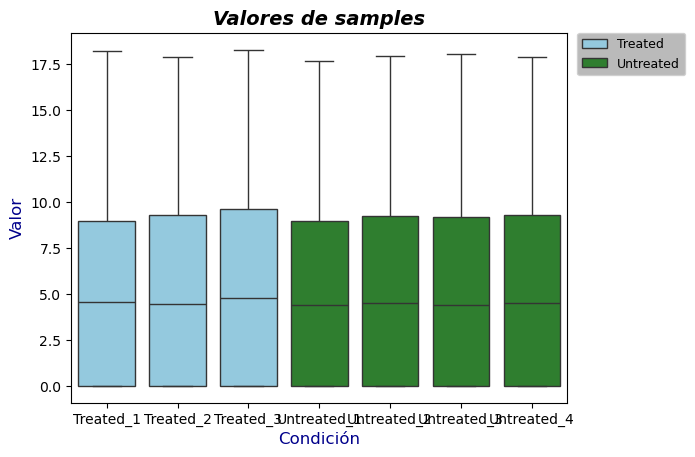

In [5]:
# Importando las bibliotecas de graficación
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=df_log_melt, x='Sample', y='Value', hue='Condition', palette={'Treated':'skyblue', 'Untreated':'forestgreen'})

# Agregar títulos y etiquetas
plt.title("Valores de samples", fontsize=14, fontweight="bold", fontstyle = "italic", color ="black")
plt.xlabel("Condición", fontsize=12, color='darkblue')
plt.ylabel("Valor", fontsize=12, color='darkblue')

# Ajustar su posición posición y cambiar tamaño de letra
plt.legend(
    bbox_to_anchor=(1.02, 1),   # posición fuera del eje
    loc='upper left',           # punto de anclaje de la leyenda
    borderaxespad=0,
    fontsize = 9,
    title_fontsize=2,
    labelcolor = "black",
    facecolor = 'darkgrey'
)

Las siguientes gráficas que exploraremos son las de **densidad**. Estas gráficas permiten visualizar la **distribución de los valores** de manera continua, mostrando dónde se concentran los datos y facilitando la comparación entre muestras o condiciones.

Para generar estas gráficas utilizaremos la función `displot` de **Seaborn** con el tipo `kde` (Kernel Density Estimation), que permite trazar la **estimación de la densidad**:

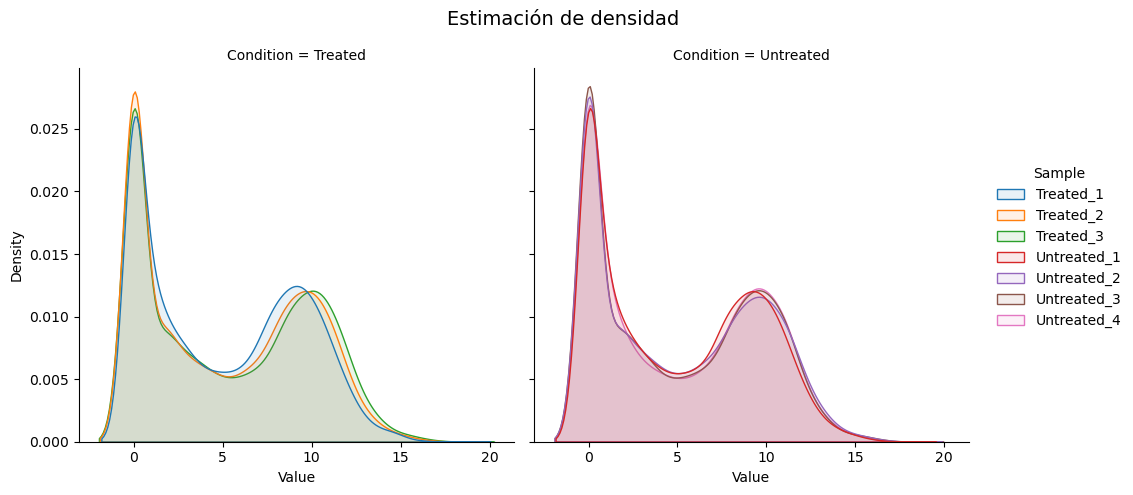

In [6]:
# Generando las gráficas de densidad
graf = sns.displot(
    data=df_log_melt,
    x='Value',
    hue='Sample',
    col='Condition',
    kind='kde',
    fill=True,
    alpha=0.1
)

#Agregando titulos
graf.figure.suptitle('Estimación de densidad', fontsize=14)
graf.tight_layout()
plt.show()




### 4.2 PCA

Para explorar la **variabilidad general de los datos** y detectar patrones entre muestras, realizamos un **Análisis de Componentes Principales (PCA)**.

El **PCA** reduce la dimensionalidad de los datos al transformar las variables originales en **componentes principales** ortogonales que capturan la mayor parte de la **varianza total**. Esto permite representar relaciones complejas en un espacio más compacto y fácil de interpretar.

En Python, el cálculo de las **componentes principales** se puede realizar utilizando la clase `PCA` del módulo `sklearn.decomposition`, como se muestra en el siguiente código:


In [7]:
df_log.T

,ID=FBgn0000003,ID=FBgn0000008,ID=FBgn0000014,ID=FBgn0000015,ID=FBgn0000017,ID=FBgn0000018,ID=FBgn0000022,ID=FBgn0000024,ID=FBgn0000028,ID=FBgn0000032,...,ID=FBgn0290396,ID=FBgn0290397,ID=FBgn0290398,ID=FBgn0290399,ID=FBgn0290416,ID=FBgn0290417,ID=FBgn0290418,ID=FBgn0290419,ID=FBgn0290420,ID=FBgn0290421
Treated_1,8.962896,7.375039,2.000000,1.584963,12.908393,8.724514,0.0,2.807355,4.087463,9.951285,...,8.438792,9.306062,1.584963,7.467606,13.211888,7.179909,10.162391,10.131857,7.199672,10.211888
Treated_2,9.521600,7.622052,1.000000,1.000000,12.673972,9.052568,0.0,4.247928,3.459432,10.230020,...,8.724514,10.258566,2.000000,7.629357,13.900678,7.643856,10.622967,10.391244,7.442943,10.693487
Treated_3,10.009829,7.658211,1.000000,1.000000,12.981210,9.252665,0.0,3.321928,2.807355,10.533330,...,9.044394,10.453271,1.584963,7.912889,14.072300,8.005625,10.858758,10.754052,7.800900,10.997885
Untreated_1,8.823367,7.491853,3.000000,1.000000,13.244215,8.721099,1.0,3.169925,3.459432,9.837628,...,8.569856,9.469642,2.000000,7.276124,13.513481,7.592457,10.396605,11.308908,7.434628,10.178665
Untreated_2,8.888743,8.033423,0.000000,1.000000,13.300496,8.909893,0.0,2.807355,0.000000,10.252665,...,8.550747,10.049849,0.000000,7.294621,14.139871,7.665336,10.753217,11.638888,7.467606,10.460456
Untreated_3,9.513728,7.607330,0.000000,1.584963,12.786882,9.014020,0.0,2.807355,0.000000,10.158610,...,8.876517,9.908393,2.321928,7.651052,13.609525,7.794416,10.733863,11.460968,7.672425,10.702173
Untreated_4,8.071462,7.622052,2.321928,1.000000,12.771077,9.233620,0.0,3.906891,2.584963,10.598983,...,8.909893,9.791163,2.321928,7.864186,13.617238,7.707359,10.752381,11.477252,7.658211,10.398744


In [8]:
# Cargando la función PCA de la biblioteca sklearn
from sklearn.decomposition import PCA

# Transponer para que los genes queden en columnas
expresion_df = df_log.T # Para transponer

# Inicia el modelo de Análisis de Componentes Principales, para evaluar 2 componentes
pca = PCA(n_components=2) # Creación de objeto PCA

# Calculando las componentes principales
pcs = pca.fit_transform(expresion_df) # Para escalar los datos
print(pcs)

# Creando un dataframe con las componentes, para su posterior graficación
pca_df = pd.DataFrame(data=pcs, columns=['PC1', 'PC2'], index=expresion_df.index)
pca_df['Condition'] = pca_df.index.str.replace('_.$', '', regex=True)

display(pca_df)


[[ 64.80299227 -34.78879453]
 [-23.73331094 -31.00408354]
 [-51.66931806 -38.58804819]
 [ 52.50886823  15.25889032]
 [-15.34814511  31.63775512]
 [-19.0550792   31.11925236]
 [ -7.50600719  26.36502847]]


,PC1,PC2,Condition
Treated_1,64.802992,-34.788795,Treated
Treated_2,-23.733311,-31.004084,Treated
Treated_3,-51.669318,-38.588048,Treated
Untreated_1,52.508868,15.258890,Untreated
Untreated_2,-15.348145,31.637755,Untreated
Untreated_3,-19.055079,31.119252,Untreated
Untreated_4,-7.506007,26.365028,Untreated


Una vez calculadas las **componentes principales**, podemos **visualizar la dispersión de las muestras** en el espacio formado por las dos primeras componentes (PC1 y PC2), mediante un **diagrama de dispersión**.  

Para ello, utilizamos la función `scatterplot` de **seaborn**, que permite representar cada muestra como un punto y diferenciar las condiciones experimentales mediante colores:


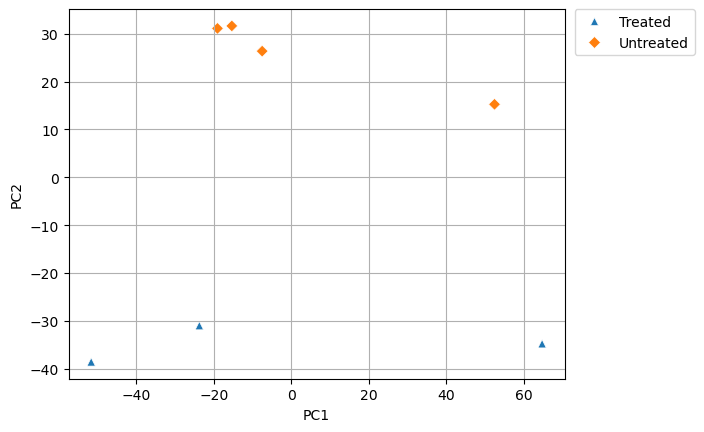

In [9]:
# Graficando la pca con un scatterplot
#formas=["^","D"]
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Condition', style='Condition', markers={'Treated': '^', 'Untreated': 'D'})



# Ajustar su posición de la leyenda y cambiar tamaño de letra
plt.legend(
    bbox_to_anchor=(1.02, 1),   # posición fuera del eje
    loc='upper left',           # punto de anclaje de la leyenda
    borderaxespad=0,
    fontsize = 10,
    title_fontsize=12
)
plt.grid(True)
plt.show()




# Examinando las variables que tiene la variación




El sitio donde se puede obtener la información en Seaborn es https://seaborn.pydata.org/tutorial/properties.html?utm_source=chatgpt.com y en Matplotlib es https://matplotlib.org/stable/api/markers_api.html?utm_source=chatgpt.com. A continuación se presenta una tabla con algunos de ellos.

| Código | Descripción                           |     Código     | Descripción                             |                  |
| :----: | ------------------------------------- | :------------: | --------------------------------------- | ---------------- |
|  `"."` | Punto                                 |      `","`     | Pixel (más pequeño)                     |                  |
|  `"o"` | Círculo                               |      `"v"`     | Triángulo hacia abajo                   |                  |
|  `"^"` | Triángulo hacia arriba                |      `"<"`     | Triángulo hacia la izquierda            |                  |
|  `">"` | Triángulo hacia la derecha            |      `"1"`     | Triángulo hacia abajo (estrecho)        |                  |
|  `"2"` | Triángulo hacia arriba (estrecho)     |      `"3"`     | Triángulo hacia la izquierda (estrecho) |                  |
|  `"4"` | Triángulo hacia la derecha (estrecho) |      `"s"`     | Cuadrado                                |                  |
|  `"p"` | Pentágono                             |      `"P"`     | Cruz gruesa (plus filled)               |                  |
|  `"*"` | Estrella                              |      `"h"`     | Hexágono 1                              |                  |
|  `"H"` | Hexágono 2                            |      `"+"`     | Cruz                                    |                  |
|  `"x"` | X                                     |      `"X"`     | X gruesa (filled)                       |                  |
|  `"D"` | Diamante                              |      `"d"`     | Diamante delgado                        |                  |
|  `"\|"` | Línea vertical                              |      `"_"`     | Línea horizontal                        |                  |


## 5. Filtrando datos poco significativos

Una manera sencilla de filtrar los datos es eliminar aquellos genes que tengan cero conteos en todas las muestras. Esto permite reducir el tamaño de la tabla y enfocar el análisis únicamente en los genes que presentan algún nivel de expresión, como se muestra en el siguiente código:

In [10]:
# Filtrando los genes que tienen al menos un conteo mayor a cero en alguna columna



# Impresión del número de filas resultantes




Para un análisis más robusto, se utilizan los **conteos por millón (CPM)**, que ajustan los conteos de cada gen según la **profundidad de secuenciación** de cada muestra. Así, se calcula la proporción de lecturas por gen, se multiplica por 1 millón y se filtran los genes con expresión muy baja en la mayoría de las muestras, siguiendo lo recomendado por **Anders et al. (2013)**, quienes sugieren filtrar genes con CPM menor a un umbral **U** en al menos **n muestras**, donde **n** es el tamaño del grupo más pequeño de réplicas.  

A continuación definiremos la función `cpm()` y filtraremos los genes con **CPM > 5 en al menos 3 muestras** (ya que el grupo más pequeño de réplicas es 3), eliminando los genes poco expresados:

In [11]:
# Función para calcular los conteos por millón

def cpm(df):
    """
    Calcula los conteos por millón (CPM) de un DataFrame de conteos brutos.

    Args:
        df (pd.DataFrame): DataFrame con valores numéricos (conteos de genes)
    
    Returns:
        pd.DataFrame: DataFrame con los valores de CPM
    """
    return (df / df.sum()) * 1000000

In [ ]:
# Filtrando la tabla de conteos, con U = 5 
# en un número mínimo de muestras n= 3
df_CountFilter= df_count[(cpm(df_count) >= 5).sum(axis=1) >= 3]
display(df_CountFilter.head())



# Impresión del número de filas resultantes
print(df_CountFilter.shape)


# Guardando el dataframe con la matriz de conteos filtrada
df_CountFilter.to_csv("data/FilterCount.csv")




## 6. Análisis de expresión diferencial  

Para realizar el **análisis de expresión diferencial**, utilizaremos la biblioteca **pydeseq2**.

Como paso inicial, reorganizaremos la **tabla de conteos** para que los **genes estén en columnas** y las **muestras en filas**, el formato requerido por esta biblioteca.


In [13]:
# Cargando los modulos de pydeseq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from pydeseq2.preprocessing import deseq2_norm

import os
df_CountFilter = pd.read_csv("/export/space3/users/lvega/FilterCount.csv", index_col=0)
print(df_CountFilter.head())

# Haciendo la transpuesta de la tabla de conteos
df_CountFilter_T = df_CountFilter.T
print(df_CountFilter_T.head())


                Treated_1  Treated_2  Treated_3  Untreated_1  Untreated_2  \
ID=FBgn0000003        498        734       1030          452          473   
ID=FBgn0000008        165        196        201          179          261   
ID=FBgn0000017       7687       6534       8085         9702        10088   
ID=FBgn0000018        422        530        609          421          480   
ID=FBgn0000032        989       1200       1481          914         1219   

                Untreated_3  Untreated_4  
ID=FBgn0000003          730          268  
ID=FBgn0000008          194          196  
ID=FBgn0000017         7066         6989  
ID=FBgn0000018          516          601  
ID=FBgn0000032         1142         1550  
             ID=FBgn0000003  ID=FBgn0000008  ID=FBgn0000017  ID=FBgn0000018  \
Treated_1               498             165            7687             422   
Treated_2               734             196            6534             530   
Treated_3              1030             20

### 6.1 Creación de la matriz de diseño o metadata  

Primero, creamos la **matriz de diseño** (o **metadata**), que especifica la **asociación entre las muestras y sus respectivas condiciones experimentales**. Esta información es fundamental para que PyDESeq2 pueda identificar qué grupos serán comparados durante el análisis.



In [14]:
# Creación de la matriz de diseño
Condiciones=df_CountFilter.columns.str.replace("_.$", "", regex=True)
metadata = pd.DataFrame(Condiciones, columns=["condition"], index=df_CountFilter_T.index)
print(metadata)

             condition
Treated_1      Treated
Treated_2      Treated
Treated_3      Treated
Untreated_1  Untreated
Untreated_2  Untreated
Untreated_3  Untreated
Untreated_4  Untreated


### 6.2 Creación del objeto DESeqData

DESeq2 trabaja con objetos de tipo `DESeqData`, los cuales almacenan toda la información necesaria para realizar el análisis de **expresión diferencial**. 

Para crear este objeto, se requiere **la tabla de conteos**, la **matriz de diseño** y el nombre de la **columna** dentro de la metadataque contiene la **condición experimental de cada muestra**.

La creación del objeto se realiza mediante la función `DeseqDataSet`

In [15]:
# Creando el objeto dds
dds = DeseqDataSet(
    counts = df_CountFilter_T,
    metadata = metadata
)
print(dds)

AnnData object with n_obs × n_vars = 7 × 7565
    obs: 'condition'
    obsm: 'design_matrix'


### 6.3 Normalización y cálculo de dispersión


Una vez creado el objeto `DeseqDataSet`, se ejecuta el método `deseq2()`, el cual lleva a cabo varios pasos fundamentales del análisis de expresión diferencial.  

Primero, realiza la **normalización** de los conteos mediante la estimación de **factores de tamaño**, que compensan las diferencias en la **profundidad de secuenciación** entre muestras. Después, estima la **dispersión** de cada gen, que representa la **variabilidad biológica** entre réplicas, y finalmente ajusta el modelo estadístico para calcular los **cambios en la expresión génica (log₂ fold change)** entre las condiciones experimentales.  

In [16]:
# Aplicar el método deseq2 a los datos
dds.deseq2()
print(dds)


Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.



Fitting dispersions...
... done in 0.92 seconds.

Fitting dispersion trend curve...
... done in 0.15 seconds.

Fitting MAP dispersions...
... done in 0.91 seconds.

Fitting LFCs...


AnnData object with n_obs × n_vars = 7 × 7565
    obs: 'condition', 'size_factors', 'replaceable'
    var: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', '_LFC_converged', 'replaced', 'refitted', '_pvalue_cooks_outlier'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', '_mu_LFC', '_hat_diagonals'
    varm: 'LFC'
    layers: 'normed_counts', '_mu_hat', 'cooks'


... done in 0.88 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



En este punto, los **parámetros del análisis** se almacenan organizando los campos por claves. En particular:

- **`X`** almacena los **datos de conteo**.  
- **`obs`** contiene información **a nivel de muestra (1D)**, como los **factores de diseño** y los **`size_factors`** utilizados en la normalización.  
- **`obsm`** guarda información **multidimensional a nivel de muestra**, como la **matriz de diseño (`design_matrix`)**.  
- **`var`** almacena información **a nivel de gen (1D)**, como los **nombres de los genes** y las **dispersiónes (`dispersions`)** estimadas.  
- **`varm`** contiene información **multidimensional a nivel de gen**, como los **valores de cambio en la expresión (`LFC`)**.

Como ejemplo, a continuación se muestra cómo podemos acceder a las  muestras y valores de **normalización**, a las **dispersiónes** y a los **valores de cambio en la expresión (LFCs)** en **escala logarítmica natural**:



In [17]:
# Solicitando la información de las muestras
print("***** Información de las muestras *****")
print(dds.obs)

# Solicitando la información de la dispersión
print("***** Información de la dispersión *****")
print(dds.var["dispersions"])

# Solicitando los valores de cambio LFC
print("***** Información de LFC *****")
print(dds.varm["LFC"])

***** Información de las muestras *****
             condition  size_factors  replaceable
Treated_1      Treated      0.799779        False
Treated_2      Treated      1.046468        False
Treated_3      Treated      1.329037        False
Untreated_1  Untreated      0.847613        False
Untreated_2  Untreated      1.037561        False
Untreated_3  Untreated      1.012299        False
Untreated_4  Untreated      1.024738        False
***** Información de la dispersión *****
ID=FBgn0000003    0.068823
ID=FBgn0000008    0.024924
ID=FBgn0000017    0.047958
ID=FBgn0000018    0.013916
ID=FBgn0000032    0.018574
                    ...   
ID=FBgn0290417    0.013449
ID=FBgn0290418    0.006246
ID=FBgn0290419    0.007588
ID=FBgn0290420    0.015239
ID=FBgn0290421    0.011763
Name: dispersions, Length: 7565, dtype: float64
***** Información de LFC *****
                Intercept  condition[T.Untreated]
ID=FBgn0000003   6.551008               -0.350766
ID=FBgn0000008   5.197378                0.

### 6.4 Análisis estadístico con la clase `DeseqStats`

Una vez realizada la **normalización**, el cálculo de la **dispersión** y obtenidos los **valores de cambio en la expresión (LFC)**, se pueden realizar las **pruebas estadísticas** para calcular los **p-values** y los **p-values ajustados**, fundamentales para identificar genes diferencialmente expresados.

Para ello, utilizaremos la función `DeseqStats`, que requiere dos argumentos obligatorios:

- **`dds`**: el objeto `DESeqDataSet` que contiene la información de **normalización** y **dispersión**.  
- **`contrast`**: una lista de 3 cadenas de la forma `["variable", "condición_prueba", "condición_basal"]`, que define la comparación de interés.

La función crea un objeto de la clase `DeseqStats`, que se utilizará posteriormente para calcular los **p-values** y realizar el análisis estadístico de la expresión diferencial.

In [18]:
# Creando el objeto de tipo DeseqStats
ds = DeseqStats(dds, contrast=["condition", "Treated","Untreated"])
print(ds)

Finalmente, utilizando la función `summary()` se ejecutan todas las **pruebas estadísticas**, calculando los **p-values** y los **p-values ajustados**, haciendo uso de la información de normalización y dispersión previamente almacenada en el objeto `DeseqStats`.

In [19]:
# EvaluandoCalculando las pruebas estadísticas
ds.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: condition Treated vs Untreated
                   baseMean  log2FoldChange     lfcSE       stat  \
ID=FBgn0000003   581.553898        0.506048  0.292610   1.729425   
ID=FBgn0000008   198.640785       -0.225887  0.191154  -1.181701   
ID=FBgn0000017  8129.732194       -0.257709  0.241624  -1.066572   
ID=FBgn0000018   506.839036       -0.049217  0.138938  -0.354237   
ID=FBgn0000032  1198.792684       -0.070504  0.153535  -0.459206   
...                     ...             ...       ...        ...   
ID=FBgn0290417   200.761957       -0.163078  0.149870  -1.088128   
ID=FBgn0290418  1564.227216       -0.195499  0.091528  -2.135940   
ID=FBgn0290419  2230.316827       -1.131744  0.099549 -11.368688   
ID=FBgn0290420   183.448528       -0.166023  0.158825  -1.045320   
ID=FBgn0290421  1469.364428        0.110165  0.122893   0.896429   

                      pvalue          padj  
ID=FBgn0000003  8.373302e-02  3.958329e-01  
ID=FBgn0000008  2.373243

... done in 0.94 seconds.



Los resultados obtenidos al aplicar la función `summary()` se almacenan en el atributo `results_df`, que es un **DataFrame**.  

In [20]:
# Guardando los resultados en res_df_pyDESeq2
res_df_pyDESeq2 = ds.results_df
res_df_pyDESeq2.head()

# Guardando los resultados en un archivo
res_df_pyDESeq2.to_csv("../tmp/ExpDifRes.txt") 

Entre los atributos disponibles se encuentran:

- **`padj`**: p-value ajustado, útil para controlar la tasa de falsos positivos.  
- **`log2FoldChange`**: cambio en la expresión en escala log₂ entre condiciones.

Estos valores permiten **identificar y filtrar genes con expresión diferencial significativa**.

## 7. Interpretación de resultados

### 7.1 Genes sub y sobre expresados

Para obtener los nombres de los genes que se encuentran **sobreexpresados** o **subexpresados**, realizaremos un **filtrado de los resultados**, considerando los siguientes criterios:

- **Magnitud del cambio (`log2FoldChange`)**: al menos ±2  
- **p-value ajustado (`padj`)**: ≤ 0.01

Este filtrado nos permitirá identificar genes con cambios de expresión **estadísticamente significativos** y de **magnitud relevante**.

Esta tarea la realizaremos con la función `select` de la biblioteca **NumPy**:


In [28]:
# Si los resultados de la ED, están en un archivo. Leer el archivo
res_df_pyDESeq2=pd.read_csv("../tmp/ExpDifRes.txt", index_col = 0)


# Definir las condiciones con los valores de corte
cond = [ (res_df_pyDESeq2["padj"] <= 0.01) & (res_df_pyDESeq2["log2FoldChange"] >= 2),(res_df_pyDESeq2["padj"] <= 0.01) & (res_df_pyDESeq2["log2FoldChange"] <= -2)]

# Definir los valores correspondientes
opc = ["UP", "DOWN"]

# Crear la nueva columna
res_df_pyDESeq2["Expression"] = np.select(cond, opc, default = "Non-DE")


# Desplegando el dataframe
display(res_df_pyDESeq2.head())





,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Expression
ID=FBgn0000003,581.553898,0.506048,0.292610,1.729425,0.083733,0.395833,Non-DE
ID=FBgn0000008,198.640785,-0.225887,0.191154,-1.181701,0.237324,0.680232,Non-DE
ID=FBgn0000017,8129.732194,-0.257709,0.241624,-1.066572,0.286165,0.729228,Non-DE
ID=FBgn0000018,506.839036,-0.049217,0.138938,-0.354237,0.723161,0.945672,Non-DE
ID=FBgn0000032,1198.792684,-0.070504,0.153535,-0.459206,0.646086,0.921136,Non-DE


Para conocer cuántos valores hay en cada categoría (**UP**, **DOWN** y **Non-DE**), utilizaremos el método `value_counts()` de **pandas**.


In [29]:
# Contando los valores asociados a cada categoría de la columna Expresion

conteo = res_df_pyDESeq2["Expression"].value_counts()
print(conteo)



Expression
Non-DE    7541
DOWN        20
UP           4
Name: count, dtype: int64


### 7.2 Interpretación grafica de los resultados

Una forma eficaz de **resumir e interpretar** los resultados del análisis de expresión diferencial es mediante su **visualización gráfica**. Para ello, utilizaremos dos tipos de representaciones: el **volcano plot** y los **mapas de calor (heatmaps)**, que permiten identificar patrones y genes diferencialmente expresados de manera más intuitiva.

### 7.2.1 Gráfica de Volcano

El **volcano plot** es una gráfica de dispersión que combina la **magnitud del cambio de expresión** (`log2FoldChange`) con la **significancia estadística** (`-log10(padj)`), permitiendo identificar de forma rápida los genes **sobreexpresados** y **subexpresados** de manera significativa.

Antes de generar la gráfica, calcularemos el valor de `-log10(padj)` utilizando la biblioteca **NumPy**, ya que este valor se empleará para representar el eje **Y** de la gráfica.


In [30]:
# Crear la columna log10Neg
res_df_pyDESeq2["log10Neg"] = -np.log10(res_df_pyDESeq2["padj"])
display(res_df_pyDESeq2.head())




,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Expression,log10Neg
ID=FBgn0000003,581.553898,0.506048,0.292610,1.729425,0.083733,0.395833,Non-DE,0.402488
ID=FBgn0000008,198.640785,-0.225887,0.191154,-1.181701,0.237324,0.680232,Non-DE,0.167343
ID=FBgn0000017,8129.732194,-0.257709,0.241624,-1.066572,0.286165,0.729228,Non-DE,0.137136
ID=FBgn0000018,506.839036,-0.049217,0.138938,-0.354237,0.723161,0.945672,Non-DE,0.024259
ID=FBgn0000032,1198.792684,-0.070504,0.153535,-0.459206,0.646086,0.921136,Non-DE,0.035676


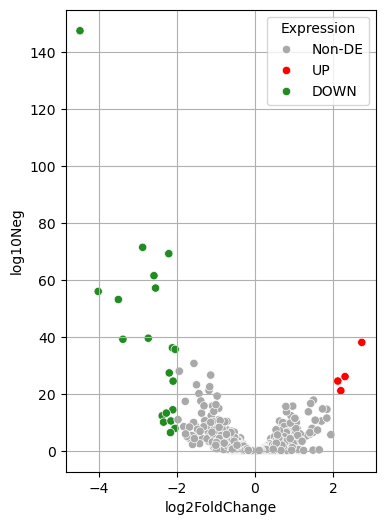

In [31]:
# Creando la gráfica de puntos
plt.figure(figsize=(4,6))
colores = {
    "UP": "red",
    "DOWN": "forestgreen",
    "Non-DE": "darkgray",
}

sns.scatterplot(data=res_df_pyDESeq2, x="log2FoldChange", y="log10Neg", hue = "Expression", palette = colores)
plt.grid(True)
plt.show()








### 7.2.2 Heatmap

Además de la **gráfica de Volcano**, también podemos generar un **mapa de calor (heatmap)** para visualizar y contrastar la expresión de los **genes diferencialmente expresados** de manera significativa entre condiciones.  

Para ello, primero **obtenemos los conteos normalizados** utilizando la función `deseq2_norm()` y seleccionamos únicamente los **genes significativos** (aquellos clasificados como *UP* o *DOWN*).  

Posteriormente, aplicamos una **normalización tipo Z-score por gen**, lo que permite centrar y escalar los valores de expresión, facilitando la comparación entre muestras y genes.  

Finalmente, utilizamos la función `clustermap()` de **seaborn**, que genera el mapa de calor agrupando tanto los genes como las muestras según su similitud en los patrones de expresión.


In [25]:
# Obtener los conteos normalizados, estos dependen de la biblioteca de pydeseq2
# Existen dos maneras de obtenerlos
# 1. Con la función deseq2_norm(
#normalizacion = deseq2_norm(df_CountFilter_T)

# 2. Directamente del objeto dds
#normCounts = pd.DataFrame(dds.layers['normed_counts'].T,index=dds.var_names,columns=dds.obs_names)#normalizacion[0]

#display(normCounts)


,Treated_1,Treated_2,Treated_3,Untreated_1,Untreated_2,Untreated_3,Untreated_4
ID=FBgn0000003,622.672377,701.407080,774.997214,533.262210,455.876922,721.131119,261.530366
ID=FBgn0000008,206.307113,187.296713,151.237320,211.181273,251.551536,191.643064,191.268477
ID=FBgn0000017,9611.410769,6243.860843,6083.351915,11446.260975,9722.804197,6980.154088,6820.282570
ID=FBgn0000018,527.646071,506.465603,458.226508,496.688917,462.623515,509.731037,586.491605
ID=FBgn0000032,1236.592331,1146.714572,1114.340654,1078.322256,1174.870967,1128.125668,1512.582341
...,...,...,...,...,...,...,...
ID=FBgn0290417,180.049844,190.163500,192.620667,226.518461,194.687396,218.315037,202.978792
ID=FBgn0290418,1431.646329,1506.018471,1396.499834,1589.168577,1662.553255,1681.322142,1682.381907
ID=FBgn0290419,1401.638022,1282.409129,1298.684651,2991.931337,3072.591176,2783.763688,2781.199789
ID=FBgn0290420,182.550536,165.318017,167.038234,202.922788,169.628622,200.533722,196.147775


Index(['ID=FBgn0000071', 'ID=FBgn0000406', 'ID=FBgn0002868', 'ID=FBgn0003360',
       'ID=FBgn0011260', 'ID=FBgn0016715', 'ID=FBgn0024315', 'ID=FBgn0026562',
       'ID=FBgn0029167', 'ID=FBgn0029896', 'ID=FBgn0034389', 'ID=FBgn0034736',
       'ID=FBgn0035085', 'ID=FBgn0037754', 'ID=FBgn0038832', 'ID=FBgn0039155',
       'ID=FBgn0039827', 'ID=FBgn0040827', 'ID=FBgn0052407', 'ID=FBgn0261584',
       'ID=FBgn0262733', 'ID=FBgn0264272', 'ID=FBgn0264475', 'ID=FBgn0264753'],
      dtype='object')


,Treated_1,Treated_2,Treated_3,Untreated_1,Untreated_2,Untreated_3,Untreated_4
ID=FBgn0000071,6.629970,6.659051,6.768551,4.855280,4.933202,4.922339,4.394702
ID=FBgn0000406,4.639846,4.655482,4.937678,6.224098,6.215104,6.508416,5.460463
ID=FBgn0002868,4.090441,3.421766,3.653802,5.467878,4.742567,4.878218,5.585126
ID=FBgn0003360,7.221747,7.069387,7.027651,9.176226,8.924113,9.015997,9.250288
ID=FBgn0011260,6.263198,5.910537,5.836566,4.617905,4.517400,4.331742,4.529701
ID=FBgn0016715,3.979953,4.259272,4.219004,5.665967,5.601616,5.684911,5.468727
ID=FBgn0024315,2.918033,3.357325,3.764353,4.798579,5.167341,5.050449,5.134761
ID=FBgn0026562,9.279303,9.762494,9.846142,10.937322,11.457370,11.549435,11.036828
ID=FBgn0029167,7.214413,7.399440,7.215704,8.733949,8.893230,8.811426,8.787219
ID=FBgn0029896,5.464108,5.201848,5.329874,6.808922,6.938577,6.740061,6.675094


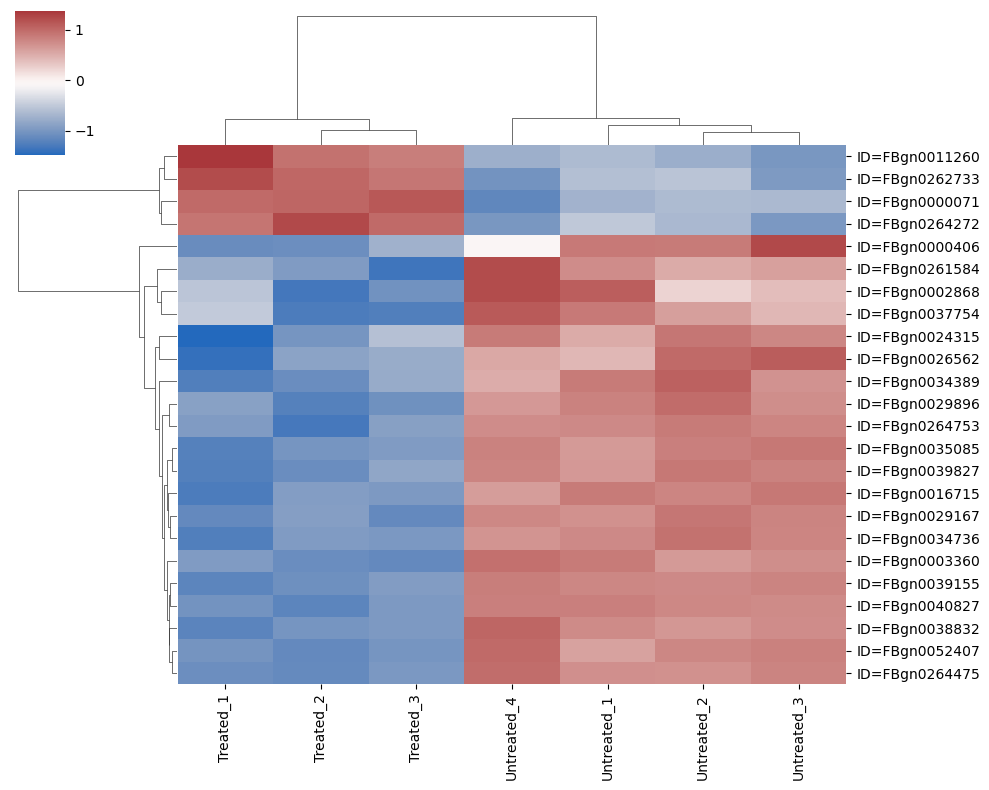

In [32]:
# Si los conteos normalizados están en un archivo. Leer el archivo
normCounts = pd.read_csv("../tmp/ConteosNormaliz.csv", index_col = 0)
display(normCounts)
# Seleccionando los genes significativos
genes = res_df_pyDESeq2[res_df_pyDESeq2["Expression"] != "Non-DE"].index
print(genes)

# Aplicando un logaritmo a los conteos para achatar picos
heatmap_data = np.log1p(normCounts.loc[genes])
display(heatmap_data)




# Graficando el heatmap
import seaborn as sns
import matplotlib.pyplot as plt

sns.clustermap(data= heatmap_data,
              z_score=0,
              cmap="vlag",
              col_cluster=True,
              row_cluster=True,
              figsize =(10,8))

plt.show()



